In [1]:
import pandas as pd
import numpy as np
import sklearn
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, Ridge
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error as mae

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

## Load data

In [2]:
df = pd.read_csv('../data/fairlymade_products_impacts.csv')

## Drop product_types with too few items

In [3]:
# minimum number of products per product types
threshold = 20
n_instances_before_dropping = len(df)

all_product_types = df['product_type'].unique()

# find the product types to drop
product_type_count = df['product_type'].value_counts()
product_types_to_drop = product_type_count[product_type_count < threshold].index

# drop the product types with less than threshold number of items
df = df[~df['product_type'].isin(product_types_to_drop)]

print(f"Dropping {len(product_types_to_drop)} out of {len(product_type_count)} product_types because they have less then {threshold} items")
print(f"Percentage of instances dropped {round(100*(n_instances_before_dropping-len(df))/len(df), 2)}%")

Dropping 4 out of 34 product_types because they have less then 20 items
Percentage of instances dropped 0.38%


## Split the data

In [4]:
drop_columns = ['study_id', 'resource_use_fossils']
target = ['climate_change']

# drop the target from training data
drop_columns.extend(target)

# 70% of data goes to train, stratify on product_type
train, test = train_test_split(df, test_size=0.3, stratify=df['product_type'], random_state=0)
# 15% of data goes to test and 15% to eval, stratify on product_type
test, val = train_test_split(test, test_size=0.5, stratify=test['product_type'], random_state=0)

# Prepare training data and target vector
X_train, y_train = train.drop(columns=drop_columns), train[target].values.ravel()
X_val, y_val = val.drop(columns=drop_columns), val[target].values.ravel()
X_test, y_test = test.drop(columns=drop_columns), test[target].values.ravel()

In [5]:
print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"X_val: {len(X_val)}, y_val: {len(y_val)}")
print(f"X_test: {len(X_test)}, y_test: {len(y_test)}")

X_train: 6219, y_train: 6219
X_val: 1333, y_val: 1333
X_test: 1333, y_test: 1333


## Preprocessing pipeline

In [23]:
# convert columns to string type
# it helps with vectorizing and handling null values
def convert_col_to_string(df, cols=['product_type', 'composition', 'raw_material_country', 
                                'weaving_country', 'dyeing_country', 'manufacturing_country']):
    for col in cols:
        df[col] = df[col].astype(str)
    return df

In [24]:
def generate_preprocessing_transformer():
    # use one hot encoding for categories with a single word
    # use vectorizer for categories containing multiple words
    preprocessing_transformer = make_column_transformer(
        (OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=10, sparse_output=False), ['product_type']),
        (OneHotEncoder(drop='if_binary'), ['plane_in_transports']),
        (CountVectorizer(strip_accents='ascii'), 'raw_material_country'),
        (CountVectorizer(strip_accents='ascii'), 'weaving_country'),
        (CountVectorizer(strip_accents='ascii'), 'dyeing_country'),
        (CountVectorizer(strip_accents='ascii'), 'manufacturing_country'),
        (CountVectorizer(strip_accents='ascii'), 'composition'),
        remainder='drop'
    )

    return preprocessing_transformer

In [25]:
preprocessing_pipeline =  Pipeline([
        ('preprocessing', generate_preprocessing_transformer()),
    ])

# preprocess the data
X_train = convert_col_to_string(X_train)
X_val = convert_col_to_string(X_val)
X_test = convert_col_to_string(X_test)

X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

# check that the preprocesed data looks ok. We probably need more checks here [idea for production code]
X_train_preprocessed

<6219x283 sparse matrix of type '<class 'numpy.float64'>'
	with 48610 stored elements in Compressed Sparse Row format>

## Train the model

In [26]:
model_list = {
               'Ridge': Ridge(),
               'DecisionTree Regressor': DecisionTreeRegressor(),
               'Random Forest': RandomForestRegressor(), 
               'SVR': SVR(), 
               'KNN Regressor': KNeighborsRegressor(),
               'XGBRegressor': XGBRegressor(),
               'Lasso': Lasso(),
               'KernelRidge': KernelRidge(),
               'ElasticNet': ElasticNet(),
               'GradientBoostingRegressor': GradientBoostingRegressor()
              }

# use mean and median absolute error because they are less sensitive to large errors which will happen.
scoring = {'neg_mean_absolute_error':'neg_mean_absolute_error', 'neg_median_absolute_error': 'neg_median_absolute_error', 'r2':'r2'}
columns = ['Model', 'Median fit time', 'Mean abs error', 'Std abs error', 'Median abs error', 'Std Median abs error', 'Mean r2', 'Std r2']

# use cross validation with 5 folds
folds = KFold(n_splits=5, shuffle=True, random_state=0)

In [28]:
model_perf_matrix = []
predictions = pd.DataFrame()
for model_name, model in tqdm(model_list.items()):
    # create preprocessing and training pipeline
    pipeline = Pipeline([ 
        ('preprocessing', generate_preprocessing_transformer()),
        ('model', model)
    ])

    # train the pipeline on the folds to get a better estimate absolute error and the std absolute error.
    cv_score = cross_validate(pipeline, X_train, y_train, cv=folds, scoring=scoring, verbose=0, error_score="raise");
    model_perf_matrix.append([model_name, round(cv_score['fit_time'].mean(),3),
                                          round(-cv_score['test_neg_mean_absolute_error'].mean(),4), 
                                          round(cv_score['test_neg_mean_absolute_error'].std(),4),
                                          round(-cv_score['test_neg_median_absolute_error'].mean(),4), 
                                          round(cv_score['test_neg_median_absolute_error'].std(),4),
                                          round(cv_score['test_r2'].mean(),4), round(cv_score['test_r2'].std(),4)])

    # fit the pipeline on all the training data to predict validation data
    pipeline.fit(X_train, y_train)
    predictions[model_name] = pipeline.predict(X_val).T

# build the model performance dataframe
df_model_perf = pd.DataFrame(model_perf_matrix, columns=columns)
df_model_perf

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.10s/it]


,Model,Median fit time,Mean abs error,Std abs error,Median abs error,Std Median abs error,Mean r2,Std r2
0,Ridge,0.083,12.3132,0.6724,6.1702,0.2832,0.5449,0.0252
1,DecisionTree Regressor,0.160,8.2519,0.2498,2.5747,0.1356,0.6680,0.0501
2,Random Forest,6.957,7.6266,0.4473,2.6423,0.1143,0.7391,0.0331
3,SVR,1.351,11.3073,0.4325,3.5838,0.1161,0.3148,0.0280
4,KNN Regressor,0.068,9.5042,0.4944,3.4023,0.1050,0.6082,0.0390
5,XGBRegressor,0.141,7.9263,0.5094,2.9271,0.1258,0.7350,0.0389
6,Lasso,0.077,14.6654,0.3606,8.9408,0.3197,0.4170,0.0300
7,KernelRidge,1.192,12.2968,0.6735,6.1297,0.3360,0.5445,0.0252
8,ElasticNet,0.076,17.3171,0.3754,11.9040,0.2694,0.1864,0.0167
9,GradientBoostingRegressor,0.249,9.5656,0.4315,4.5961,0.1366,0.6923,0.0121


## Analyse predictions

In [29]:
predictions['label'] = y_val
predictions

,Ridge,DecisionTree Regressor,Random Forest,SVR,KNN Regressor,XGBRegressor,Lasso,KernelRidge,ElasticNet,GradientBoostingRegressor,label
0,13.470959,12.472909,13.982494,15.824836,15.259967,12.175664,5.956887,14.177837,9.103895,19.735030,12.178119
1,62.748462,78.184941,79.516078,32.861656,70.660626,77.888763,77.128668,62.633539,35.619234,53.012212,91.948182
2,0.410560,6.984949,6.786478,6.339246,5.128972,5.273140,13.900364,0.292950,17.611345,7.428152,6.815810
3,26.157813,15.798639,16.061916,17.238265,14.992545,19.032478,13.900364,25.951896,17.926515,20.231491,14.716049
4,16.982425,6.987076,6.371121,10.190521,12.353431,7.796122,17.872102,16.286746,23.430663,12.391543,5.331121
...,...,...,...,...,...,...,...,...,...,...,...
1328,3.912336,4.345440,4.210526,9.069501,3.379569,5.083318,17.872102,3.707318,22.858529,7.443683,4.341375
1329,3.735005,2.677243,2.868221,9.046104,4.638255,6.757689,12.388404,2.779848,15.350309,6.923488,2.523200
1330,9.756810,10.816239,10.740222,11.612676,10.038342,11.730863,13.900364,9.983479,19.342273,12.160687,11.788730
1331,33.594122,32.264075,31.996150,27.846688,31.227749,28.045702,21.060438,33.367570,27.492851,24.968007,30.412119


In [30]:
# calculate the median absolute error on the evaluation split.
for col in predictions.columns[0:-1]:
    print(f"val Median absolute error of {col}: {round(mae(y_true=y_val, y_pred=predictions[col]), 3)}")

val Median absolute error of Ridge: 6.315
val Median absolute error of DecisionTree Regressor: 2.347
val Median absolute error of Random Forest: 2.428
val Median absolute error of SVR: 3.408
val Median absolute error of KNN Regressor: 3.261
val Median absolute error of XGBRegressor: 2.792
val Median absolute error of Lasso: 8.586
val Median absolute error of KernelRidge: 6.238
val Median absolute error of ElasticNet: 11.728
val Median absolute error of GradientBoostingRegressor: 4.415


### Regression plot

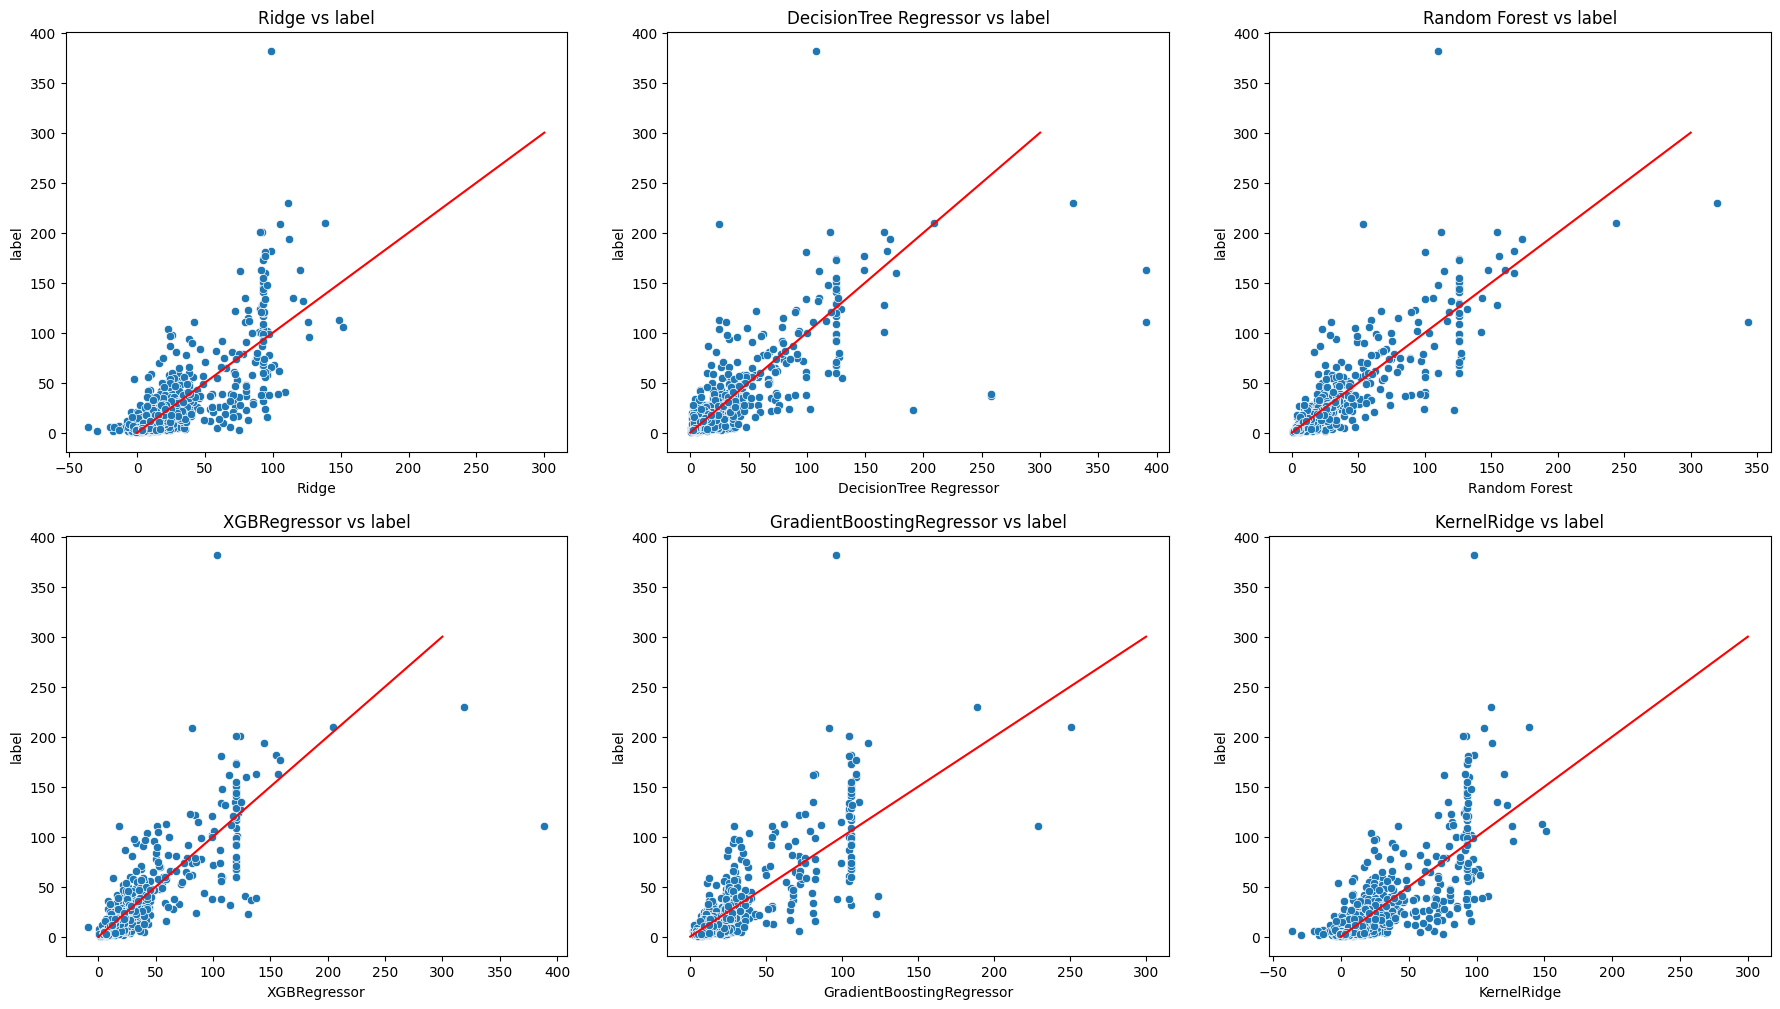

In [13]:
lim = 300

fig, ax = plt.subplots(2,3, figsize=(22,12))
sns.scatterplot(x="Ridge", y="label", data=predictions, ax=ax[0][0])
ax[0][0].set_title('Ridge vs label');
ax[0][0].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="DecisionTree Regressor", y="label", data=predictions, ax=ax[0][1])
ax[0][1].set_title('DecisionTree Regressor vs label');
ax[0][1].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="Random Forest", y="label", data=predictions, ax=ax[0][2])
ax[0][2].set_title('Random Forest vs label');
ax[0][2].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="XGBRegressor", y="label", data=predictions, ax=ax[1][0])
ax[1][0].set_title('XGBRegressor vs label');
ax[1][0].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="GradientBoostingRegressor", y="label", data=predictions, ax=ax[1][1])
ax[1][1].set_title('GradientBoostingRegressor vs label');
ax[1][1].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="KernelRidge", y='label', data=predictions, ax=ax[1][2])
ax[1][2].set_title('KernelRidge vs label');
ax[1][2].plot([0, lim], [0, lim], c = "red")

### How close are the predictions?

In [33]:
df_results = predictions[['DecisionTree Regressor', 'label']]
df_results.loc[df_results['DecisionTree Regressor'] < 1, 'DecisionTree Regressor'] = 1
df_results['dtr_low'] = df_results['DecisionTree Regressor'] * 0.75
df_results['dtr_high'] = df_results['DecisionTree Regressor'] * 1.25
df_results['correct'] = (df_results['label'] > df_results['dtr_low']) & (df_results['label'] < df_results['dtr_high'])
df_results['correct'] = df_results['correct'].astype(int)
df_results.describe()

/tmp/ipykernel_206548/2727836301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['dtr_low'] = df_results['DecisionTree Regressor'] * 0.75
/tmp/ipykernel_206548/2727836301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results['dtr_high'] = df_results['DecisionTree Regressor'] * 1.25
/tmp/ipykernel_206548/2727836301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,DecisionTree Regressor,label,dtr_low,dtr_high,correct
count,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000
mean,22.713479,21.944933,17.035109,28.391849,0.555139
std,33.848709,31.350334,25.386532,42.310886,0.497137
min,1.000000,0.778126,0.750000,1.250000,0.000000
25%,6.119300,5.836683,4.589475,7.649125,0.000000
50%,11.844551,11.988237,8.883414,14.805689,1.000000
75%,24.699638,23.742241,18.524728,30.874547,1.000000
max,390.866919,381.848120,293.150189,488.583649,1.000000


56% of the evaluation split is correctly predicted when using a 25% amrgin around the prediction.

### Predictions visualization

/home/maxou1909/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/maxou1909/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


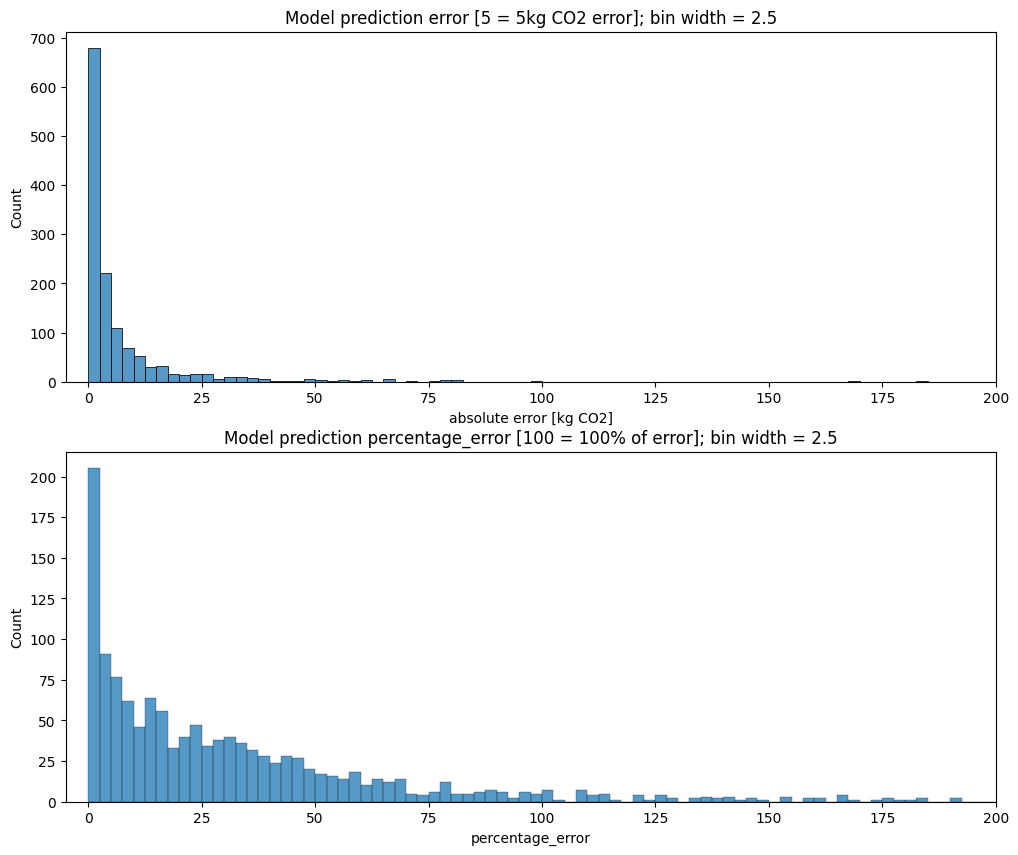

In [34]:
X_val = val.drop(columns=drop_columns)
# calculate absolute error and percentage error
predictions['absolute error [kg CO2]'] = np.abs(predictions['DecisionTree Regressor'] - predictions['label'])
predictions['percentage_error'] = 100*predictions['absolute error [kg CO2]']/predictions['label']

fig, ax = plt.subplots(2,1, figsize=(12,10))
sns.histplot(data=predictions, x="absolute error [kg CO2]", ax=ax[0],binwidth=2.5)
ax[0].set_title('Model prediction error [5 = 5kg CO2 error]; bin width = 2.5');
ax[0].set_xlim([-5, 200])

sns.histplot(data=predictions, x="percentage_error", ax=ax[1], binwidth=2.5)
ax[1].set_title('Model prediction percentage_error [100 = 100% of error]; bin width = 2.5');
ax[1].set_xlim([-5, 200])
plt.show()

### Is there a difference in prediction performance depending on the product type?

In [16]:
X_val = val.drop(columns=drop_columns)
predictions['product_type'] = X_val['product_type'].values
# calculate percentage error
predictions['percentage_error'] = np.abs(predictions['DecisionTree Regressor'] - predictions['label'])/predictions['label']

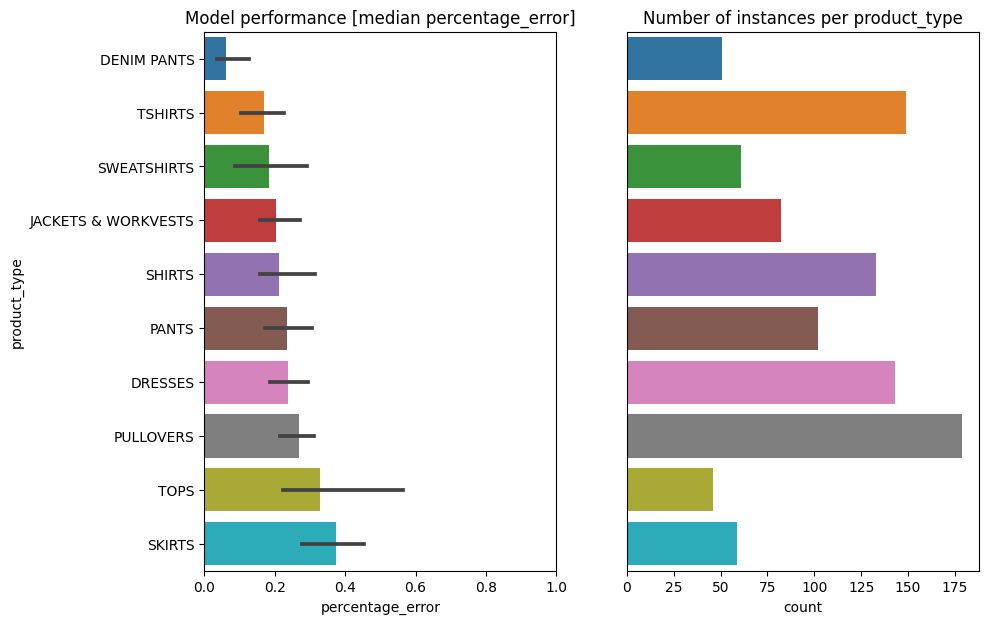

In [17]:
df = predictions.copy()

# select product_types which are most frequent
most_frequent_type = predictions['product_type'].value_counts()[0:10].index
df = df[df['product_type'].isin(most_frequent_type)]

# calculate the order to plot the graph
order = df.groupby('product_type').agg({'percentage_error':'median'}).sort_values('percentage_error').index

fig, ax = plt.subplots(1,2, figsize=(10,7))
sns.barplot(data=df, y="product_type", x="percentage_error", estimator=np.median, order=order, errorbar='ci', ax=ax[0])
ax[0].set_title('Model performance [median percentage_error]');
ax[0].set_xlim([0, 1])

sns.countplot(data=df, y="product_type", order=order, ax=ax[1])
ax[1].set_title('Number of instances per product_type');
ax[1].set(ylabel=None)
ax[1].get_yaxis().set_visible(False)
plt.show()

### Is there a difference in prediction performance depending on the number of missing data?

In [18]:
X_val = val.drop(columns=drop_columns)
predictions['nb_missing_data'] = X_val.isnull().sum(axis=1).values

# calculate absolute error and percentage error
predictions['absolute error [kg CO2]'] = np.abs(predictions['DecisionTree Regressor'] - predictions['label'])
predictions['percentage_error'] = 100*predictions['absolute error [kg CO2]']/predictions['label']

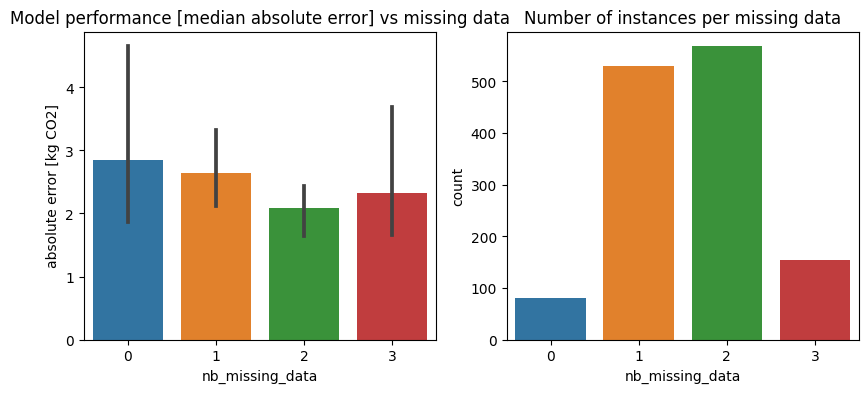

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=predictions, x="nb_missing_data", y="absolute error [kg CO2]", estimator=np.median, errorbar='ci', ax=ax[0])
ax[0].set_title('Model performance [median absolute error] vs missing data');

sns.countplot(data=predictions, x="nb_missing_data", ax=ax[1])
ax[1].set_title('Number of instances per missing data');
plt.show()